In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class PokemonDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.types = {
                "Normal": 0,
                "Fire": 1,
                "Water": 2,
                "Electric": 3,
                "Grass": 4,
                "Ice": 5,
                "Fighting": 6,
                "Poison": 7,
                "Ground": 8,
                "Flying": 9,
                "Psychic": 10,
                "Bug": 11,
                "Rock": 12,
                "Ghost": 13,
                "Dragon": 14,
                "Dark": 15,
                "Steel": 16,
                "Fairy": 17
            }
        self.types_inverse = {v: k for k, v in self.types.items()}

    def get_type(self, label):
        return [self.types_inverse[i.item()] for i in label.nonzero()]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]

        img_name = os.path.join(self.root_dir, row["img_name"])
        image = Image.open(img_name).convert("RGB")

        label = torch.zeros(18)

        type_1 = self.types[row["type_1"]]
        label[type_1] = 1


        if not pd.isna(row["type_2"]) and row["type_2"] != "None":
            type_2 = self.types[row["type_2"]]
            label[type_2] = 1

        if self.transform:
            image = self.transform(image)

        return image, label


In [11]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

data_path = "data.csv"
images_path = "pokemon_images"
save_path = "./type_classifier_net.pth"
### Comment out if not using Google Colab ###

# from google.colab import drive
# drive.mount('/content/drive')
# data_path = "/content/drive/MyDrive/Colab Notebooks/Pokemon Type Classifier/data.csv" # Path to data.csv
# images_path = "/content/drive/MyDrive/Colab Notebooks/Pokemon Type Classifier/pokemon_images" # Path to images
# save_path = "/content/drive/MyDrive/Colab Notebooks/Pokemon Type Classifier/type_classifier_net.pth"

### Comment out if not using Google Colab ###


dataset = PokemonDataset(data_path, images_path, transform=transform)
loader = DataLoader(dataset, batch_size=4, num_workers=0)

In [12]:
# def get_mean_and_std(loader):
#     mean = 0.
#     std = 0.
#     count = 0
#     for images, _ in loader:
#         batch_size = images.size(0)
#         images = images.view(batch_size, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         count += batch_size
#     mean /= count
#     std /= count

#     return mean, std
# mean, std = get_mean_and_std(loader)

#Results from get_mean_and_std()
mean = torch.tensor([0.7993, 0.7868, 0.7648])
std = torch.tensor([0.2696, 0.2697, 0.2848])

dataset.transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [13]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

In [14]:
train_images, labels = next(iter(train_loader))

C:\Users\josep\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


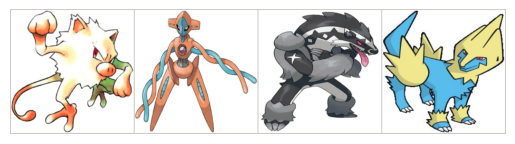

['Fighting']
['Psychic']
['Normal', 'Dark']
['Electric']


In [15]:
def imshow(img):
    img = img * std[:, None, None] + mean[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
    plt.show()

imshow(torchvision.utils.make_grid(train_images[0:4]))

for i in range(4):
    types = dataset.get_type(labels[i])
    print(types)

<img src="convnet.jpeg" width="500" alt="Image for ConvNet structure" />
<a href="https://cs231n.github.io/convolutional-networks/">Architecture for ConvNet</a>
<p>INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC</p>
<p>So in this case, N = 2, M = 3, K = 0</p>
<p>Formula for output size: [Input size - Kernel size + 2 * Padding] / Stride + 1, where stride = 1, and padding = 0.</p>
<p>Or simply just subtract 4 from the original input size</p>

In [16]:
# Input size of images
train_images.shape

torch.Size([32, 3, 256, 256])

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 256, 5)
        self.conv6 = nn.Conv2d(256, 512, 5)

        self.fc1 = nn.Linear(512 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 18) # 18 Types including None

    def forward(self, input):
        c1 = F.relu(self.conv1(input)) # Takes in input image tensor, outputs tensor with size (N, 16, 252, 252), where N = batch_size (4)
        c2 = F.relu(self.conv2(c1)) # Tensor (N, 16, 252, 252) -> Tensor (N, 32, 248, 248)
        p1 = F.max_pool2d(c2, (2,2)) # Tensor (N, 32, 248, 248) -> Tensor (N, 32, 124, 124)
        c3 = F.relu(self.conv3(p1)) # Tensor (N, 32, 124, 124) -> Tensor (N, 64, 120, 120)
        c4 = F.relu(self.conv4(c3)) # Tensor (N, 64, 120, 120) -> Tensor (N, 128, 116, 116)
        p2 = F.max_pool2d(c4, (2,2)) # Tensor (N, 128, 116, 116) -> Tensor (N, 128, 58, 58)
        c5 = F.relu(self.conv5(p2)) # Tensor (N, 128, 58, 58) -> Tensor (N, 256, 54, 54)
        c6 = F.relu(self.conv6(c5)) # Tensor (N, 256, 54, 54) -> Tensor (N, 512, 50, 50)
        p3 = F.max_pool2d(c6, (2,2)) # Tensor (N, 512, 50, 50) -> Tensor (N, 512, 25, 25)

        flat = torch.flatten(p3, 1) # Tensor (N, 512, 25, 25) -> Tensor (N, 512 * 25 * 25)
        f1 = self.fc1(flat)
        f2 = self.fc2(f1)
        out = self.fc3(f2)

        return out

net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=18, bias=True)
)

In [81]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(25):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [84]:
torch.save(net.state_dict(), save_path)

In [20]:
test_net = ConvNet()
test_net.load_state_dict(torch.load(save_path, weights_only=True, map_location="cpu"))

<All keys matched successfully>

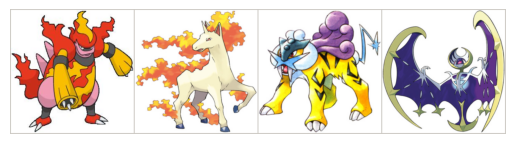

GroundTruths: 
['Fire']
['Fire']
['Electric']
['Psychic', 'Ghost']


In [70]:
test_images, labels = next(iter(test_loader))

imshow(torchvision.utils.make_grid(test_images))

print("GroundTruths: ")
for i in range(4):
    types = dataset.get_type(labels[i])
    print(types)

In [104]:
def predict(net, images):
    
    outs = net(images)
    outs = torch.sigmoid(outs)
    predictions = []
    
    for out in outs:
        if (out > 0.5).sum().item() > 2:
            _, indicies = torch.topk(out, 2)
            pred = torch.zeros(18)
            pred[indicies[0]] = 1
            pred[indicies[1]] = 1
            predictions.append(pred)
            
        elif (out > 0.5).sum().item() <= 0:
            _, indicies = torch.topk(out, 1)
            pred = torch.zeros(18)
            pred[indicies[0]] = 1
            predictions.append(pred)
        else:
            predictions.append(torch.where(out > 0.5, 1, 0))

    return torch.stack(predictions)

In [106]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        predictions = predict(test_net, images)
        
        total += labels.size(0)
        correct += (predictions == labels).all(dim=1).sum().item()

print(f"Accuracy on {total} test images: {100 * correct // total}%")
        

Accuracy on 501 test images: 79%
